In [482]:
# 23122003 Nguyễn Văn Linh
# 23122022 Trần Hoàng Gia Bảo
# 23122026 Trần Chấn Hiệp
# 23122040 Nguyễn Thị Mỹ Kim

In [483]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import json
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [484]:
class MyPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X):
        # Chuẩn hóa dữ liệu
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) 
        Xnew = (X - self.mean_) / self.std_
        
        # Tính ma trận hiệp phương sai cho dữ liệu
        cov_matrix = np.dot(Xnew.T, Xnew) / (Xnew.shape[0] - 1)
        
        # Tính trị riêng và vector riêng cho ma trận hiệp phương sai
        eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix) # tránh việc trả về số phức
        sorted_indices = np.argsort(eigen_values)[::-1] # trả về index sắp xếp theo trị tiêng giảm dần
        
        # Sắp xếp lại các trị riêng và các vector riêng
        self.eigen_values = eigen_values[sorted_indices]
        self.eigen_vectors = eigen_vectors[:, sorted_indices]
        
        # Các thành phần chính (n_components)
        self.selected_eigen_vectors = self.eigen_vectors[:, :self.n_components]
        
        # Tổng phương sai của dữ liệu
        total_var = self.eigen_values.sum()
        
        # EVR: Tỉ lệ phương sai được nắm giữ bởi các thành phần PCA
        self.explained_variance_ratio_ = self.eigen_values[:self.n_components] / total_var
        
        # CEVR: Tổng tích lũy tỉ lệ phương sai được nắm giữ bởi các thành phần PCA
        self.cumulative_explained_variance_ratio_ = np.cumsum(self.explained_variance_ratio_)
        
    def transform(self, X):
        Xnew = (X - self.mean_) / self.std_
        # Chiếu dữ liệu X lên các thành phần chính
        return np.dot(Xnew, self.selected_eigen_vectors)

In [485]:
def plot2D(X, y):
    if X.shape[1] < 2:
        raise ValueError("plot2D requires at least 2 dimensions")
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, alpha=0.7)
    plt.colorbar(label='True Label')
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()

def plot3D(X, y):
    if X.shape[1] < 3:
        raise ValueError("plot3D requires at least 3 dimensions")
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='coolwarm', s=30, alpha=0.7)
    fig.colorbar(p, label='True Label')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.grid(True)
    plt.show()


In [486]:
class MyKMeans:
    def __init__(self, n_clusters, n_init=30, random_state=1):
        self.n_init = n_init
        self.n_clusters = n_clusters
        np.random.seed(random_state)

    def _init_centroids(self, X):
        # Chọn random K mẫu dữ liệu trong X để khởi tạo các điểm trung tâm (centroids)
        centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        return centroids
    
    def cluster_single(self, X):
        """
        Chạy cluster trong 1 lần init (có tất cả n_init lần)
        """
        centroids = self._init_centroids(X)
        labels = np.full(X.shape[0], -1, dtype=np.int32)
        
        best_inertia = np.inf
        best_labels = None
        best_centroids = None
        
        for it in range(300):
            # ASSIGN LABELS WITH CENTROIDS
            ## Tính khoảng cách giữa các centroids với dữ liệu bằng bình phương khoảng cách Euclidean
            distance = cdist(X, centroids, metric='sqeuclidean')
            # Tại mẫu dữ liệu thứ i: Trả về index của centroid_k mà centroid_k đó gần với mẫu dữ liệu thứ i nhất
            new_labels = np.argmin(distance, axis=1)
            
            # UPDATE CENTROIDS 
            new_centroids = np.zeros_like(centroids)
            for k in range(self.n_clusters):
                # Lấy tất cả những điểm được gán là dữ liệu gán với label k của centroid_k
                Xk = X[new_labels == k]
                # Cập nhật new_centroid_k bằng trung bình của các điểm dữ liệu có label k
                new_centroids[k] = np.mean(Xk, axis=0)
                
            # Tổng khoảng cách của mỗi điểm tới centroid đã gán (inertia)
            inertia = np.sum(np.min(distance, axis=1))
            if best_inertia > inertia:
                best_inertia = inertia
                best_labels = new_labels
                best_centroids = new_centroids
                
            # Kiểm tra hội tụ khi các điểm dữ liệu được gán là kh đổi hoặc centroids mới và cũ gần như là giống nhau 
            if np.array_equal(labels, new_labels) or np.linalg.norm(centroids - new_centroids) < 1e-5:
                break
            
            centroids = new_centroids
            labels = new_labels
            
        return best_centroids, best_labels, best_inertia
    
    def fit_predict(self, X):
        self.best_inertia = np.inf
        self.best_labels = None
        self.best_centroids = None
        
        for _ in range(self.n_init):
            centroids, labels, distance = self.cluster_single(X)
            if (self.best_inertia > distance):
                self.best_inertia = distance
                self.best_labels = labels
                self.best_centroids = centroids

        return self.best_labels
        

In [487]:
def precision(y_pred, y_true):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    return tp / (tp + fp + 1e-8)

def recall(y_pred, y_true):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return tp / (tp + fn + 1e-8)

def f1_score(y_pred, y_true):
    p = precision(y_pred, y_true)
    r = recall(y_pred, y_true)
    return 2 * p * r / (p + r + 1e-8)

def accuracy(y_pred, y_true):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def best_map_binary(y_pred, y_true, metric=accuracy):
    p1 = metric(y_pred, y_true)
    p2 = metric(1 - y_pred, y_true)
    return y_pred if p1 >= p2 else (1 - y_pred)

def print_metrics(y_pred, y_true):
    acc = accuracy(y_pred, y_true)
    r = recall(y_pred, y_true)
    p = precision(y_pred, y_true)
    f1 = f1_score(y_pred, y_true)

    print(f"Accuracy: {acc:2f}; Recall: {r:2f}; Precision: {p:2f}; f1_score: {f1:2f}")


In [488]:
df = pd.read_csv("ABIDE2(updated).csv")
df.head()

,Unnamed: 0,site,subject,age,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,0,ABIDEII-KKI_1,29293,8.893151,Cancer,2750.0,306.0,354.0,2123.0,1451.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,1,ABIDEII-OHSU_1,28997,12.000000,Cancer,2836.0,186.0,354.0,2261.0,1584.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,2,ABIDEII-GU_1,28845,8.390000,Normal,3394.0,223.0,373.0,2827.0,1816.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3,ABIDEII-NYU_1,29210,8.300000,Cancer,3382.0,266.0,422.0,2686.0,1893.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,4,ABIDEII-EMC_1,29894,7.772758,Normal,3080.0,161.0,346.0,2105.0,1307.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [489]:
# Kiểm tra các giá trị NaN
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values: ", list(missing_values))

# Kiểm tra duplicate
df[df.duplicated(keep=False)]


Missing values:  []


,Unnamed: 0,site,subject,age,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI


In [490]:
df_object = df.select_dtypes(["object"])
for col_name in df_object:
    print(len(df_object[col_name].unique()), end=" unique values in ")
    print(col_name, " column: ", df_object[col_name].unique())

17 unique values in site  column:  ['ABIDEII-KKI_1' 'ABIDEII-OHSU_1' 'ABIDEII-GU_1' 'ABIDEII-NYU_1'
 'ABIDEII-EMC_1' 'ABIDEII-TCD_1' 'ABIDEII-BNI_1' 'ABIDEII-NYU_2'
 'ABIDEII-IU_1' 'ABIDEII-USM_1' 'ABIDEII-ETH_1' 'ABIDEII-SDSU_1'
 'ABIDEII-UCD_1' 'ABIDEII-IP_1' 'ABIDEII-UCLA_1' 'ABIDEII-ONRC_2'
 'ABIDEII-KUL_3']
2 unique values in group  column:  ['Cancer' 'Normal']


In [491]:
# BỎ CÁC CỘT KHÔNG ẢNH HƯỞNG NHIỀU ĐẾN KẾT QUẢ DỰ ĐOÁN MANG THÔNG TIN (LOẠI BỎ CẢ CỘT AGE DO CHỦ YẾU DỰ ĐOÁN QUA CÁC ĐẶC TRƯNG LIÊN QUAN ĐẾN NÃO)
meta_columns = ['Unnamed: 0', 'site', 'subject', 'group', 'age']
X = df.drop(columns=meta_columns)
# CỘT Y GROUND TRUTH
y_true = df['group'].map({'Cancer': 1, 'Normal': 0}).values  # Binary encoding

Thực nghiệm lần 1 đơn giản với PCA và KMeans, nhóm chọn n_components=3 (giá trị ngẫu nhiên nhóm chọn, chọn bẳng 3 cũng để có thể biểu diễn lên không gian 3 chiều). Khi quan sát hình đầu tiên, dữ liệu X đã được PCA (X_pca) và giá trị nhãn thực tế (y_true) gần như blend vào nhau. Không thể phân nhóm dữ liệu. Rõ ràng ta cũng thấy giá trị accuracy là 0.539, precision là 0.5, gần như xấp xỉ giá trị khi ta cho random nhãn 0 hoặc 1 (xác suất 1/2 = 0.5). Hình biểu diễn phân cụm của y_pred cũng chưa cho thấy sự hiệu quả.

Accuracy: 0.539841; Recall: 0.408207; Precision: 0.501326; f1_score: 0.450000


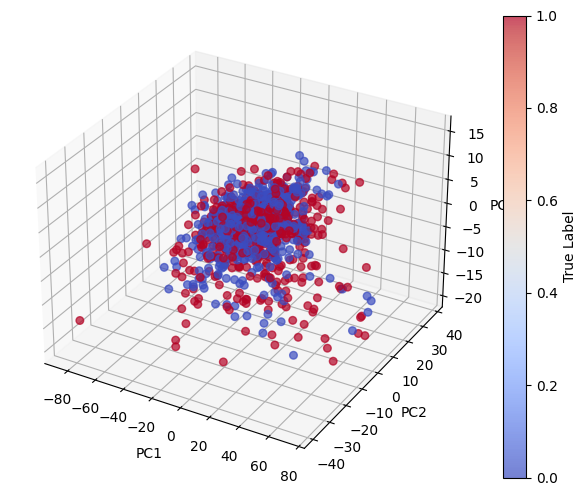

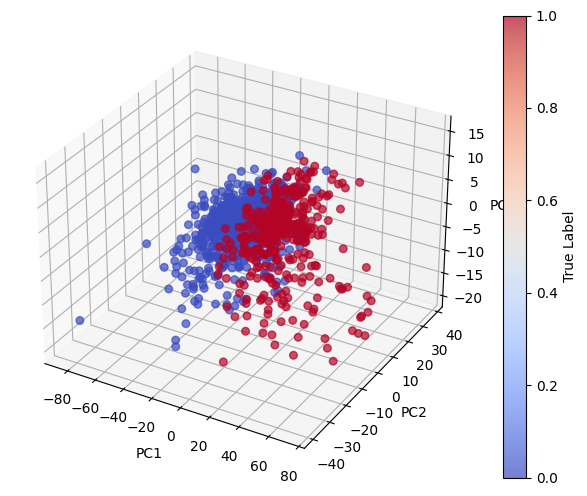

In [492]:
# Giảm số chiều bằng PCA
pca = MyPCA(n_components=3) 
pca.fit(X)
X_pca = pca.transform(X)

# Cluster thành 2 cụm 
kmeans = MyKMeans(n_clusters=2, random_state=1)
y_pred = kmeans.fit_predict(X_pca)

# Map y_pred 
y_pred = best_map_binary(y_pred=y_pred, y_true=y_true)

# Metrics
print_metrics(y_pred, y_true)

plot3D(X_pca, y_true)
plot3D(X_pca, y_pred)

Thực nghiệm lần 2 tiếp tục với PCA và KMeans, nhóm chọn n_components=50, n_components=100, n_components=500 (đều là các giá trị lớn hơn đáng kể so với 3). Kết quả đánh giá trên các metrics KHÔNG THAY ĐỔI. Điều này làm ta dự đoán đối với bất kì giá trị n_components nào thì kết quả đánh giá phân cụm dường như không đổi.

In [493]:
# Giảm số chiều bằng PCA

pca = MyPCA(n_components=100) 
pca.fit(X)
X_pca = pca.transform(X)

# Cluster thành 2 cụm 
kmeans = MyKMeans(n_clusters=2, random_state=1)
y_pred = kmeans.fit_predict(X_pca)

# Map y_pred 
y_pred = best_map_binary(y_pred=y_pred, y_true=y_true)

# Metrics
print_metrics(y_pred, y_true)

Accuracy: 0.539841; Recall: 0.408207; Precision: 0.501326; f1_score: 0.450000


In [494]:
# Giảm số chiều bằng PCA
pca = MyPCA(n_components=50) 
pca.fit(X)
X_pca = pca.transform(X)

# Cluster thành 2 cụm 
kmeans = MyKMeans(n_clusters=2, random_state=1)
y_pred = kmeans.fit_predict(X_pca)

# Map y_pred 
y_pred = best_map_binary(y_pred=y_pred, y_true=y_true)

# Metrics
print_metrics(y_pred, y_true)

Accuracy: 0.539841; Recall: 0.408207; Precision: 0.501326; f1_score: 0.450000


In [495]:
# Giảm số chiều bằng PCA
pca = MyPCA(n_components=500) 
pca.fit(X)
X_pca = pca.transform(X)

# Cluster thành 2 cụm 
kmeans = MyKMeans(n_clusters=2, random_state=1)
y_pred = kmeans.fit_predict(X_pca)

# Map y_pred 
y_pred = best_map_binary(y_pred=y_pred, y_true=y_true)

# Metrics
print_metrics(y_pred, y_true)

Accuracy: 0.539841; Recall: 0.408207; Precision: 0.501326; f1_score: 0.450000


# THỰC NGHIỆM GIẢM CHIỀU 2 GIAI ĐOẠN
Nhóm đề xuất một phương án mới, giảm chiều 2 giai đoạn. Trước tiên, ta thực hiện giảm chiều dữ liệu trên 4 nhóm chính là:
fsArea: diện tích vỏ não,
fsCt: độ dày vỏ não,
fsLgi: chỉ số độ nếp gấp vỏ não,
fsVol: thể tích vùng não.
Khi thực hiện giảm chiều trên các nhóm, ta loại bỏ được các đặc trưng dư thừa và nhiễu trên mỗi nhóm đó.
Sau đó, ta ghép các tập đặc trưng đã giảm chiều thành một tập chung rồi mới tiếp tục áp dụng PCA lần nữa trên tập đặc trưng chung này để giảm chiều tổng thể, tạo thành biểu diễn cuối cùng cho mỗi mẫu dữ liệu. 

Khi đã hoàn thành tiền xử lí dữ liệu nhờ giảm chiều 2 giai đoạn, ta sử dụng KMeans để Cluster dữ liệu thành 2 nhóm.

In [496]:
# Tách đặc trưng thành 4 nhóm chính
df_area = X[[col for col in X.columns if col.startswith('fsArea')]]
df_ct = X[[col for col in X.columns if col.startswith('fsCT')]]
df_vol = X[[col for col in X.columns if col.startswith('fsVol')]]
df_lgi = X[[col for col in X.columns if col.startswith('fsLGI')]]

Việc tìm n_component cho từng nhóm là khá là phức tạp, nhóm em chọn số component sao cho tỉ lệ CEVR chiếm khoảng 70% ở mỗi nhóm, n_component của các nhóm lúc này là 46.

In [497]:
pca_area = MyPCA(n_components=46)
pca_area.fit(df_area)
X_area_pca = pca_area.transform(df_area)
print(pca_area.cumulative_explained_variance_ratio_[-1])

0.7085477462583457


In [498]:
pca_ct = MyPCA(n_components=46)
pca_ct.fit(df_ct)
X_ct_pca = pca_ct.transform(df_ct)
print(pca_ct.cumulative_explained_variance_ratio_[-1])

0.6927189445263189


In [499]:
pca_lgi = MyPCA(n_components=46)
pca_lgi.fit(df_lgi)
X_lgi_pca = pca_lgi.transform(df_lgi)
print(pca_lgi.cumulative_explained_variance_ratio_[-1])

0.7085522953180713


Tuy nhiên ở nhóm thể tích vùng não, n = 46 chỉ thể hiện tổng phương sai tích lũy xấp xỉ 0.67, khi n = 55 (tăng 9 thuộc tính) thì thể tích vùng não mới thể hiện tổng phương sai tích lũy được 70% của nhóm này. Nhóm Volume này có thể chứa nhiều thông tin nhiễu hơn, sau khi thực hiện giảm chiều PCA lần 1 cho các nhóm và thực hiện ghép các đặc trưng lại với nhau: ta có thể thử loại bỏ đặc trưng này để xem xét kết quả.

In [500]:
pca_vol = MyPCA(n_components=46)
pca_vol.fit(df_vol)
X_vol_pca = pca_vol.transform(df_vol)
print(pca_vol.cumulative_explained_variance_ratio_[-1])

0.6714283261495282


In [501]:
pca_vol = MyPCA(n_components=55)
pca_vol.fit(df_vol)
X_vol_pca = pca_vol.transform(df_vol)
print(pca_vol.cumulative_explained_variance_ratio_[-1])

0.7020595066200703


Nhóm thử kết hợp phương pháp PCA 2 lần. Lưu ý là PCA lần 1 có đầy đủ cả 4 nhóm và đều chọn n_component = 46. Khi thực hiện PCA cho các đặc trưng đã được nối lại với nhau. Nhóm thử các cái giá trị n_component từ 40 đến 100 và rút ra kết luận sau:

+ n từ 19 đến 44: accuracy dao động trong khoảng 0.51 - 0.53
+ n = 45: accuracy = 0.578685, CEVR=0.725
+ n = 46: accuracy = 0.582669, CEVR=0.737
+ n > 46: accuracy dao động từ 0.51 đến 0.58.
 
Tuy nhiên, kết quả accuracy cao nhất trên n = 46 khi đánh giá trên các metric khác: recall khá thấp (0.328294) dẫn đến tuy precision tăng (0.584615) nhưng điểm f1 chỉ xấp xỉ 0.420470

Hình vẽ khi thể hiện trên 3 thành phần chính đầu tiên để minh họa cũng không tốt.

CEVR:  0.7369834876663965
Accuracy: 0.582669; Recall: 0.328294; Precision: 0.584615; f1_score: 0.420470


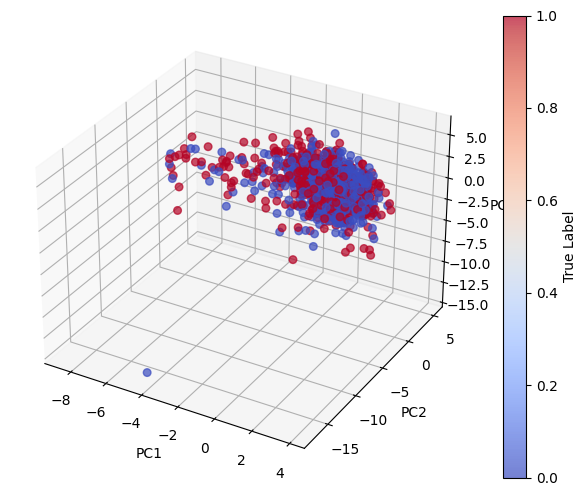

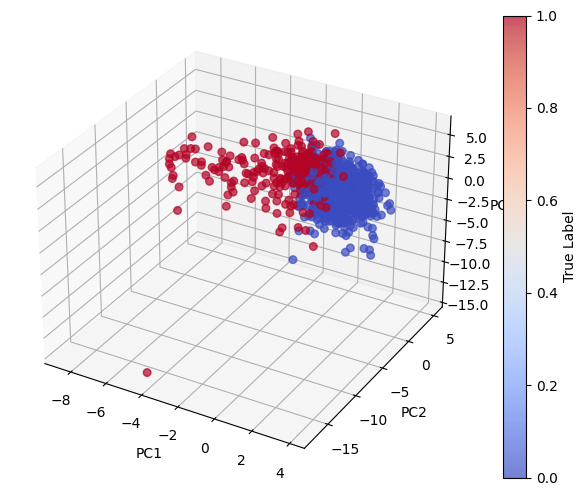

In [502]:
pca_area = MyPCA(n_components=46)
pca_area.fit(df_area)
X_area_pca = pca_area.transform(df_area)

pca_ct = MyPCA(n_components=46)
pca_ct.fit(df_ct)
X_ct_pca = pca_ct.transform(df_ct)

pca_lgi = MyPCA(n_components=46)
pca_lgi.fit(df_lgi)
X_lgi_pca = pca_lgi.transform(df_lgi)

pca_vol = MyPCA(n_components=46)
pca_vol.fit(df_vol)
X_vol_pca = pca_vol.transform(df_vol)

# Gộp thành embedding chung
X_combined = np.hstack((X_area_pca, X_lgi_pca, X_ct_pca, X_vol_pca))

pca = MyPCA(n_components=46)
pca.fit(X_combined)
X_pca = pca.transform(X_combined)
print("CEVR: ", pca.cumulative_explained_variance_ratio_[-1])

# Áp dụng KMeans lên biểu diễn chung
cluster = MyKMeans(n_clusters=2, random_state=1)
y_pred = cluster.fit_predict(X_pca)

y_pred = best_map_binary(y_pred, y_true)

print_metrics(y_pred, y_true)

plot3D(X_pca, y_true)
plot3D(X_pca, y_pred)

Nhóm thử loại bỏ thuộc tính Volume khỏi kết quả. Tức là thực hiện PCA lần 1 có chỉ có 3 nhóm. Khi thực hiện PCA cho các đặc trưng đã được nối lại với nhau. Nhóm thử các cái giá trị n_component từ 3 đến 29 và rút ra kết luận sau:

+ n từ 3 đến 5: accuracy dao động trong khoảng 0.53
+ n từ 6 đến 14 và 18, 19: accuracy xấp xỉ 0.58
+ n = 15, 16, 17: accuracy xấp xỉ 0.59
+ n = 20: accuracy xấp xỉ 0.611554, CEVR = 0.346
+ n = 21 đến 28: accurcacy khoảng 0.58
+ n = 29: accuracy khoảng 0.56
 
Kết quả accuracy cao nhất trên n = 20 khi đánh giá trên các metric khác: recall tăng (0.496760), precision tăng (0.594315), f1 tăng (0.541176) đáng kể

CEVR:  0.34564824281038553
Accuracy: 0.611554; Recall: 0.496760; Precision: 0.594315; f1_score: 0.541176


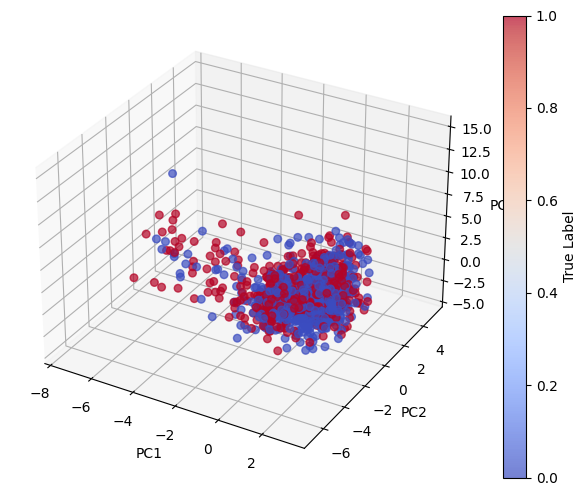

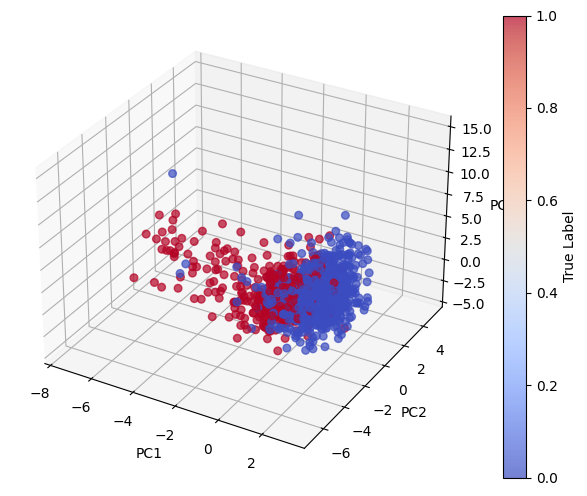

In [503]:
pca_area = MyPCA(n_components=46)
pca_area.fit(df_area)
X_area_pca = pca_area.transform(df_area)

pca_ct = MyPCA(n_components=46)
pca_ct.fit(df_ct)
X_ct_pca = pca_ct.transform(df_ct)

pca_lgi = MyPCA(n_components=46)
pca_lgi.fit(df_lgi)
X_lgi_pca = pca_lgi.transform(df_lgi)

# Gộp thành embedding chung
X_combined = np.hstack((X_area_pca, X_lgi_pca, X_ct_pca))

pca = MyPCA(n_components=20)
pca.fit(X_combined)
X_pca = pca.transform(X_combined)
print("CEVR: ", pca.cumulative_explained_variance_ratio_[-1])

# Áp dụng KMeans lên biểu diễn chung
cluster = MyKMeans(n_clusters=2, random_state=1)
y_pred = cluster.fit_predict(X_pca)

y_pred = best_map_binary(y_pred, y_true)

print_metrics(y_pred, y_true)

plot3D(X_pca, y_true)
plot3D(X_pca, y_pred)

+ fsCt – Độ dày vỏ não (Cortical thickness): Nhạy cảm với thoái hóa thần kinh (ví dụ Alzheimer, Parkinson) và thường được dùng để theo dõi sự thay đổi theo tuổi hoặc bệnh lý.
+ fsArea – Diện tích vỏ não (Surface area): Gắn với di truyền và phát triển trí tuệ.
+ fsLgi – Chỉ số độ nếp gấp (Local Gyrification Index): Gắn với sự phát triển thần kinh sớm, một số rối loạn phát triển thần kinh như tự kỷ, tâm thần phân liệt.
3 chỉ số mà ta quan tâm, dữ liệu gốc (chưa được chỉnh sửa lại có liên quan đến tự kỉ nên nhóm thử tăng n_component cho chỉ số NẾP GẤP, và quyết định chọn số 53 vì cho kết quả tổng thể cao).

Khi chọn n_components cho lần PCA thứ 2, nhóm thử các cái giá trị n_component từ 6 đến 29 và rút ra kết luận sau:
+ n từ 6 đến 19: accuracy dao động với giá trị 0.58, 0.59
+ n = 22: accuracy = 0.6026
+ n = 23: accuracy = 0.6215, CEVR: 0.37
+ n từ 24 đến 30: accuracy dao động với giá trị 0.58, 0.59
+ n = 31: accuracy = 0.51

Kết quả accuracy cao nhất trên n = 23 khi đánh giá trên các metric khác: recall tăng (0.498920), precision tăng (0.609499), f1 tăng (0.548694). 

Đây là kết quả cao nhất và kết quả điều hòa giữa các metric hơn hết. Nên đây cũng là kết quả mà nhóm submit cho lab 2

CEVR:  0.37394132122943957
Accuracy: 0.621514; Recall: 0.498920; Precision: 0.609499; f1_score: 0.548694


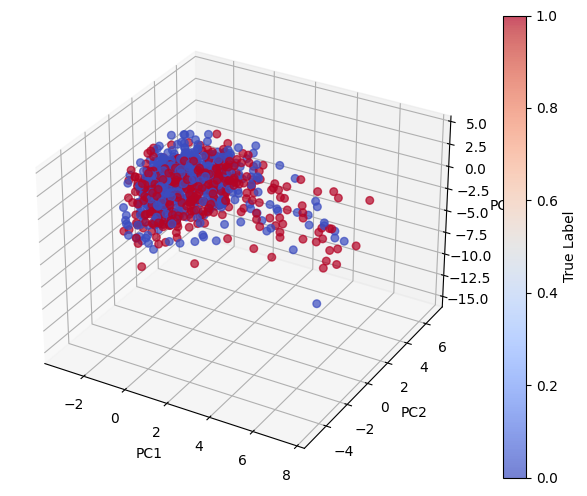

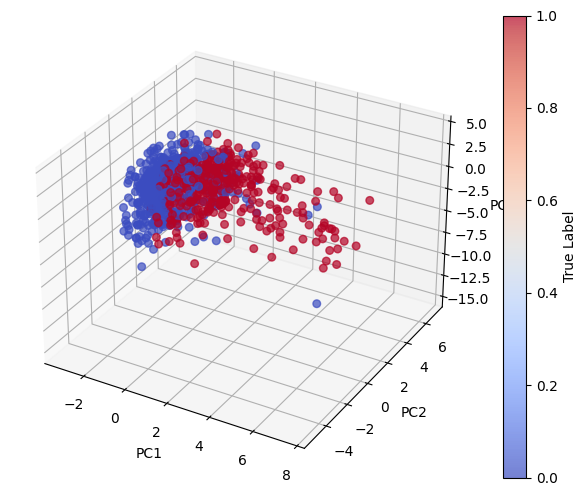

In [504]:
pca_area = MyPCA(n_components=46)
pca_area.fit(df_area)
X_area_pca = pca_area.transform(df_area)

pca_ct = MyPCA(n_components=46)
pca_ct.fit(df_ct)
X_ct_pca = pca_ct.transform(df_ct)

pca_lgi = MyPCA(n_components=53)
pca_lgi.fit(df_lgi)
X_lgi_pca = pca_lgi.transform(df_lgi)

# Gộp thành embedding chung
X_combined = np.hstack((X_area_pca, X_lgi_pca, X_ct_pca))

pca = MyPCA(n_components=23)
pca.fit(X_combined)
X_pca = pca.transform(X_combined)
print("CEVR: ", pca.cumulative_explained_variance_ratio_[-1])

# Áp dụng KMeans lên biểu diễn chung
cluster = MyKMeans(n_clusters=2, random_state=1)
y_pred = cluster.fit_predict(X_pca)

y_pred = best_map_binary(y_pred, y_true)

print_metrics(y_pred, y_true)

plot3D(X_pca, y_true)
plot3D(X_pca, y_pred)

In [505]:
print(pca_ct.cumulative_explained_variance_ratio_[-1])
print(pca_lgi.cumulative_explained_variance_ratio_[-1])
print(pca_area.cumulative_explained_variance_ratio_[-1])
print(pca.cumulative_explained_variance_ratio_[-1])

0.6927189445263189
0.7352080780403671
0.7085477462583457
0.37394132122943957
